## Preparing the Data

In [1]:
# Import needed packages
from torchvision import datasets
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Folder to download data to
data_folder = '~/Documents/Projects/PyTorch/data/FMNIST' 
# Download training data and set variable.
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [2]:
# Specify the images and labels (target)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
# Inspect the tensors
unique_values = tr_targets.unique()
print(f'tr_images & tr_targets:\n\tX - {tr_images.shape}\n\tY - {tr_targets.shape}\n\tY - Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}') 

# Shows 60,000 images that are each 28 x 28 in size and 10 possible classes across all images.

tr_images & tr_targets:
	X - torch.Size([60000, 28, 28])
	Y - torch.Size([60000])
	Y - Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
# Plot a random sample of 10 images for all the 10 possible classes.

# Import needed libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

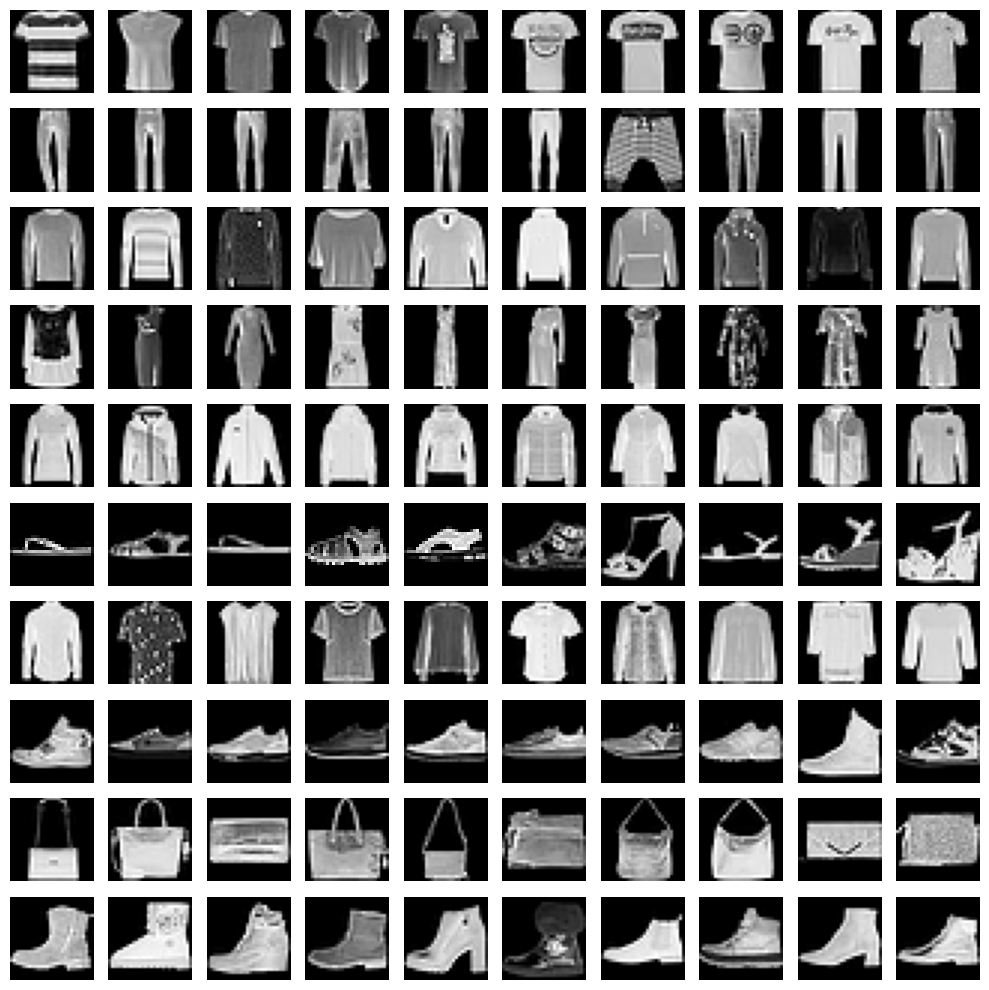

In [5]:
# Create a plot where we can show a 10 x 10 grid, where each row of the grid corresponds to a class and each column presents an example image belonging to  the row's class.
# Loop through the unique class numbers (label_class) and fetch the indices of rows (label_x_rows) corresponding to the given class number.
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

## Training a Neural Network

In [6]:
# Import needed packages
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# Build a class that fetches the dataset.
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() # Convert input into a floating-point number
        x = x.view(-1,28*28) # Flatten image into 28 x 28
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device) # Logic for what needs to be returned.
    def __len__(self): 
        return len(self.x) # Specify the number of data points.

In [8]:
# Function that generates a training DataLoader from the dataset.
# Samples 32 data points at random.
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [10]:
# Define the model, optimizer and loss function.
# Model is a network of one hidden layer with 1000 neurons.
# Output is a 10 neuron layer since there are 10 possible classes.
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss() # CrossEntropyLoss since output can belong to any one of the 10 classes.
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [11]:
# Function to train the dataset on a batch of images.
# Passes the batch of images through the model in the forward pass.
# Computes the loss on batch, passes the weights through backward propogation and updates them.
# Flushes the memory of the gradient so that it does not influence how the gradient is calculated in the next iteration.
def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach dropout section
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of     
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) where 
    # "f" is the optimizer
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

In [13]:
# Function to calculate the accuracy of a given dataset.
@torch.no_grad() # Telling it to not calculate the gradient.
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row coincides 
    # with ground truth
    max_values, argmaxes = prediction.max(-1) # Identify the argmax index corresponding to each row.
    is_correct = argmaxes == y # Compare argmax to ground truth.
    return is_correct.cpu().numpy().tolist() # Returning a list of correct objects after moving to CPU and converting to Numpy array.

In [14]:
# Initialize the model, loss, optimizer and DataLoaders
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [15]:
# Invoke the lists that contain the accuracy and loss values at the end of each epoch.
losses, accuracies = [], []

# Define the number of epochs.
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], [] # Invoke the lists that will contain the accuracy and loss values corresponding to each batch within an epoch.
    for ix, batch in enumerate(iter(trn_dl)): # Create batches of training data by iterating through the DataLoader.
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn) # Train the batch and store the loss value at the end of training on top of the batch.
        epoch_losses.append(batch_loss) # Store the loss values across batches in the list.
    epoch_loss = np.array(epoch_losses).mean() # Store the mean loss value across all batches within an epoch.
    for ix, batch in enumerate(iter(trn_dl)): # Calculate the accuracy of the prediction at the end of training on all batches.
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss) # Store the loss and acccuracy values at the end of each epoch in a list.
    accuracies.append(epoch_accuracy)

0
1
2
3
4


C:\Users\jilla\AppData\Local\Temp\ipykernel_13408\306135533.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


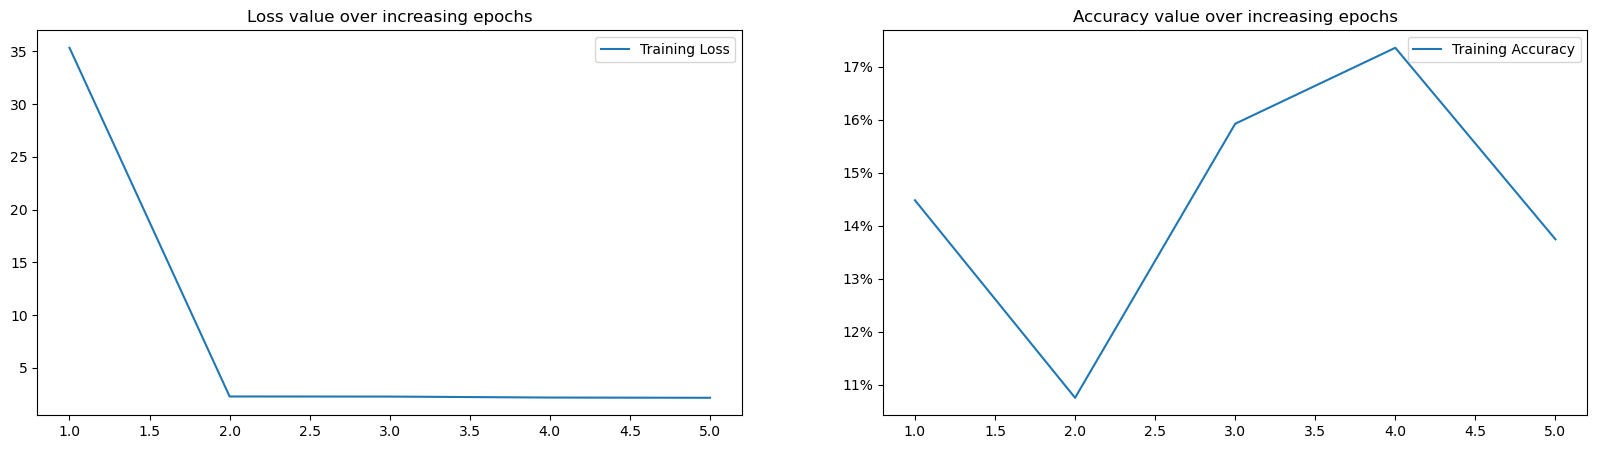

In [16]:
# Plot the variation of the training loss and accuracy over increasing epochs.
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

Training accuracy is at 12% and the loss value did not decrease significanlty over an increasing number of epochs. The model is unlikly to provide a high degree of accuracy. 

## Scaling to Improve Model Accuracy

Scaling a dataset ensures the variables are confined to a finite range. This is done by confining the independent variables to values between 0 and 1 by dividing each input value by the maximum possible value in the dataset (255/ white).

In [17]:
# Build a class that fetches the dataset and divide the input image by 255.
class SFMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255 # Convert input into a floating-point number and divide by 255.
        x = x.view(-1,28*28) # Flatten image into 28 x 28
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device) # Logic for what needs to be returned.
    def __len__(self): 
        return len(self.x) # Specify the number of data points.

In [18]:
# Function that generates a training DataLoader from the dataset.
# Samples 32 data points at random.
def get_data(): 
    train = SFMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [19]:
# Initialize the model, loss, optimizer and DataLoaders
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [20]:
# Invoke the lists that contain the accuracy and loss values at the end of each epoch.
losses, accuracies = [], []

# Define the number of epochs.
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], [] # Invoke the lists that will contain the accuracy and loss values corresponding to each batch within an epoch.
    for ix, batch in enumerate(iter(trn_dl)): # Create batches of training data by iterating through the DataLoader.
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn) # Train the batch and store the loss value at the end of training on top of the batch.
        epoch_losses.append(batch_loss) # Store the loss values across batches in the list.
    epoch_loss = np.array(epoch_losses).mean() # Store the mean loss value across all batches within an epoch.
    for ix, batch in enumerate(iter(trn_dl)): # Calculate the accuracy of the prediction at the end of training on all batches.
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss) # Store the loss and acccuracy values at the end of each epoch in a list.
    accuracies.append(epoch_accuracy)

0
1
2
3
4


C:\Users\jilla\AppData\Local\Temp\ipykernel_13408\306135533.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


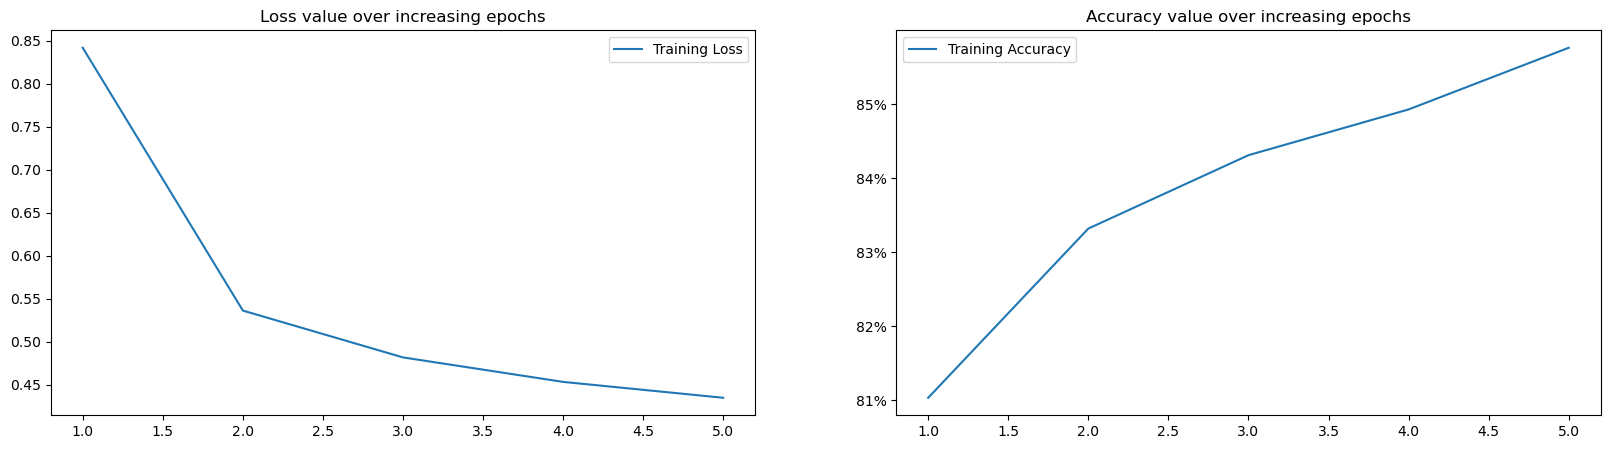

In [21]:
# Plot the variation of the training loss and accuracy over increasing epochs.
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

Scaling the data increased the model accuracy to about 85% and the training loss consistently reduced. The Sigmoid value does not change unless the weight is exremely small, so scaling to limit the range to between 0 and 1 helps the model accuracy.